In [25]:
from __future__ import print_function
import os.path
import dalmatian as dm
import pandas as pd
import gseapy
import sys
sys.path.insert(0, '../JKBio/')
import Datanalytics as da 
import TerraFunction as terra
%load_ext autoreload
from Helper import *
%autoreload 2
%load_ext rpy2.ipython
#%load_ext rpy2.ipython
from taigapy import TaigaClient
tc = TaigaClient()
import numpy as np
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from helper import pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from umap import UMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [9]:
! pip install umap-learn

     |████████████████████████████████| 40kB 1.6MB/s eta 0:00:011
     |████████████████████████████████| 3.6MB 8.2MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 31.0MB/s eta 0:00:01
  Stored in directory: /home/jeremie/.cache/pip/wheels/d0/f8/d5/8e3af3ee957feb9b403a060ebe72f7561887fef9dea658326e
Successfully built umap-learn


### downloading from [terra](gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/326e42a6-1778-459e-9a95-e5dbc8c1bb67/rsem_aggregate_results_workflow/fc5be1ee-8888-4036-8aaf-df5770b4fefa/call-rsem_aggregate_results/MAX_AMLproject.rsem_genes_expected_count.txt.gz) and unziping 

In [5]:
# biggest change genes across time point
# GSEA
#counts = pd.read_csv("data/expression.MAX_AMLproject.counts.tsv", sep='\t')
counts = pd.read_csv("data/MAX_AMLproject.rsem_genes_expected_count.txt", sep='\t')
#transcripts = pd.read_csv("data/expression.MAX_AMLproject.transcripts.tsv", sep='\t')b

In [6]:
counts.shape

(58813, 32)

In [7]:
# we have a number of non zero similar to nb of prot coding genes
np.count_nonzero(counts.values[:,2:])/30

19360.8

In [8]:
counts.columns

Index(['gene_id', 'transcript_id(s)', '0h-A-RNA', '0h-B-RNA', '0h-C-RNA',
       '1A-24h-RNA', '1A-8h-RNA', '1B-24h-RNA', '1B-8h-RNA', '1C-24h-RNA',
       '1C-8h-RNA', '2A-16h-RNA', '2A-24h-RNA', '2A-2h-RNA', '2A-4h-RNA',
       '2A-8h-RNA', '2B-16h-RNA', '2B-24h-RNA', '2B-2h-RNA', '2B-4h-RNA',
       '2B-8h-RNA', '2C-16h-RNA', '2C-24h-RNA', '2C-2h-RNA', '2C-4h-RNA',
       '2C-8h-RNA', '3A-8h-RNA', '3B-8h-RNA', '3C-8h-RNA', '4A-8h-RNA',
       '4B-8h-RNA', '4C-8h-RNA'],
      dtype='object')

filter some more

In [9]:
toremove = np.argwhere(counts[counts.columns.values[2:]].values.var(1)==0)
toremove.ravel()

array([    1,    15,    24, ..., 58809, 58810, 58811])

In [10]:
counts = counts.drop(counts.index[toremove.ravel()],0)
counts = counts.reset_index()
counts = counts.drop(columns='index')

In [11]:
counts = counts.drop('transcript_id(s)',1)
counts['gene_id'] = convertGenes(counts['gene_id'])[0]

you need access to taiga for this (https://pypi.org/project/taigapy/)
8135 could not be parsed... we don't have all genes already


The avg amount of expressed genes in the samples

In [12]:
np.count_nonzero(counts.values[:,2:])/30

18724.5

finding the different experiments

In [13]:
DMSO = '1'
MS2 = '2'
JQ1 = '3'
MS2_JQ1 = '4'
START = '0'

In [14]:
counts.columns

Index(['gene_id', '0h-A-RNA', '0h-B-RNA', '0h-C-RNA', '1A-24h-RNA',
       '1A-8h-RNA', '1B-24h-RNA', '1B-8h-RNA', '1C-24h-RNA', '1C-8h-RNA',
       '2A-16h-RNA', '2A-24h-RNA', '2A-2h-RNA', '2A-4h-RNA', '2A-8h-RNA',
       '2B-16h-RNA', '2B-24h-RNA', '2B-2h-RNA', '2B-4h-RNA', '2B-8h-RNA',
       '2C-16h-RNA', '2C-24h-RNA', '2C-2h-RNA', '2C-4h-RNA', '2C-8h-RNA',
       '3A-8h-RNA', '3B-8h-RNA', '3C-8h-RNA', '4A-8h-RNA', '4B-8h-RNA',
       '4C-8h-RNA'],
      dtype='object')

In [15]:
counts

gene_id  0h-A-RNA  0h-B-RNA  0h-C-RNA  1A-24h-RNA  1A-8h-RNA  \
0          TSPAN6      0.00      1.00      1.00        0.00        3.0   
1            DPM1    319.00    257.00    338.00      261.00      246.0   
2           SCYL3     97.37     79.53     88.76       99.19      113.7   
3        C1orf112    191.63    144.47    200.24      136.81      160.3   
4             FGR    476.00    430.00    497.00      478.00      235.0   
...           ...       ...       ...       ...         ...        ...   
30222  ERCC-00131      0.00      0.00      0.00        1.00        0.0   
30223  ERCC-00136      0.00      0.00      0.00        1.00        0.0   
30224  ERCC-00145      0.00      0.00      0.00        0.00        0.0   
30225  ERCC-00162      0.00      0.00      0.00        0.00        0.0   
30226  ERCC-00171      2.00      4.00      4.00        0.00        2.0   

       1B-24h-RNA  1B-8h-RNA  1C-24h-RNA  1C-8h-RNA  ...  2C-24h-RNA  \
0            0.00       0.00        0.00       0.00  ...        1.00   
1          259.00     352.00      169.00     374.00  ...      308.00   
2           96.48     126.73       43.64     119.06  ...      133.01   
3          160.52     209.27       82.36     137.94  ...      155.99   
4          535.00     234.00      263.00     255.00  ...      614.00   
...           ...        ...         ...        ...  ...         ...   
30222        0.00       0.00        0.00       0.00  ...        0.00   
30223        2.00       0.00        0.00       0.00  ...        1.00   
30224        0.00       0.00        1.00       0.00  ...        0.00   
30225        0.00       0.00        1.00       0.00  ...        0.00   
30226        1.00       0.00        1.00       0.00  ...        1.00   

       2C-2h-RNA  2C-4h-RNA  2C-8h-RNA  3A-8h-RNA  3B-8h-RNA  3C-8h-RNA  \
0           0.00        0.0       0.00       0.00       1.00       0.00   
1         287.00      441.0     335.00     356.00     306.00     416.00   
2         112.16      151.3     112.12     133.27     126.75     145.26   
3         125.84      131.7     143.88     117.73     111.25     136.74   
4         347.00      330.0     254.00      90.00      84.00      90.00   
...          ...        ...        ...        ...        ...        ...   
30222       1.00        1.0       0.00       0.00       0.00       0.00   
30223       0.00        0.0       2.00       2.00       1.00       0.00   
30224       0.00        0.0       0.00       0.00       1.00       0.00   
30225       0.00        0.0       0.00       0.00       0.00       0.00   
30226       1.00        2.0       2.00       0.00       4.00       2.00   

       4A-8h-RNA  4B-8h-RNA  4C-8h-RNA  
0           0.00       1.00       0.00  
1         386.00     404.00     390.00  
2         148.45     154.96     148.52  
3          90.55     121.04     117.48  
4          83.00      68.00      99.00  
...          ...        ...        ...  
30222       0.00       0.00       0.00  
30223       1.00       0.00       0.00  
30224       0.00       0.00       0.00  
30225       0.00       0.00       0.00  
30226       0.00       0.00       0.00  

[30227 rows x 31 columns]

In [16]:
DMSO = [val[0]==DMSO for val in counts.columns.values]
DMSO_t = [int(val.split('-')[1][:-1]) if val[0]==DMSO else 0 for val in counts.columns.values]
START = [val[0]==START for val in counts.columns.values]
MS2_t = [int(val.split('-')[1][:-1]) if val[0]==MS2 else 0 for val in counts.columns.values]
MS2_24 = [val == 24 for val in MS2_t]
MS2 = [val[0]==MS2 for val in counts.columns.values]
MS2_JQ1_t = [int(val.split('-')[1][:-1]) if val[0]==MS2_JQ1 else 0 for val in counts.columns.values]
MS2_JQ1 = [val[0]==MS2_JQ1 for val in counts.columns.values]
JQ1_t = [int(val.split('-')[1][:-1]) if val[0]==JQ1 else 0 for val in counts.columns.values]
JQ1 = [val[0]==JQ1 for val in counts.columns.values]

In [17]:
checks = [('0h','0h'),('1','8h'),('1','24h'),('2','2h'),('2','4h'),('2','8h'),
          ('2','16h'),('2','24h'),('3','8h'),('4','8h')]

In [18]:
design = pd.DataFrame(columns=counts.columns.values[1:], 
                      index=['START','DMSO_8','DMSO_24','MS2_2','MS2_4','MS2_8', 'MS2_16', 'MS2_24', 'JQ1_8', 'MS2_JQ1_8'], 
                      data=np.array(
                          [[1 if check[0] in val and check[1] in val else 0 for val in counts.columns.values[1:]] for check in checks]))

In [19]:
design = design.T

In [20]:
design.index = ['X'+i.replace('-','.') for i in design.index]

In [22]:
res = {}

In [55]:
design.columns.values

array(['START', 'DMSO_8', 'DMSO_24', 'MS2_2', 'MS2_4', 'MS2_8', 'MS2_16',
       'MS2_24', 'JQ1_8', 'MS2_JQ1_8'], dtype=object)

In [71]:
for val in design.columns.values[1:]:
    data = counts[[counts.columns[1:][i] for i, a in enumerate(design[['DMSO',val]].values.sum(1)) if a]+['gene_id']]
    data.columns = ['X'+i.replace('-','.') for i in data.columns]
    d = design[['START',val]][design[['START',val]].sum(1)==1]
    deseq = pyDESeq2.pyDESeq2(count_matrix=data,
                              design_matrix = d,
             design_formula="~START - "+val,
             gene_column="Xgene_id")
    deseq.run_deseq()
    deseq.get_deseq_result()
    MS2res = deseq.deseq_result
    MS2res.pvalue = np.nan_to_num(np.array(MS2res.pvalue), 1)
    MS2res.log2FoldChange = - np.nan_to_num(np.array(MS2res.log2FoldChange), 0)
    res[val] = MS2res

KeyError: "['DMSO'] not in index"

In [70]:
res.keys()

dict_keys(['DMSO_8', 'DMSO_24', 'MS2_2', 'MS2_4', 'MS2_8', 'MS2_16', 'MS2_24', 'JQ1_8', 'MS2_JQ1_8', 'START'])

In [26]:
ctf=pd.read_csv('data/CTF.csv',header=None)[0].values.tolist()
ctf.remove('IKAROS')
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [72]:
for k, val in res.items():
    a = volcano(val.rename(columns={'Xgene_id':'gene_id'}),tohighlight=ctf,title=k)
    try:
        show(a)
        save(a,k+'.html')
    except RuntimeError:
        show(a)

/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [52]:
da.log2FoldChange = da.log2FoldChange + res['DMSO_8'].log2FoldChange

In [31]:
da = res['MS2_8']
da.log2FoldChange = da.log2FoldChange - res['DMSO_8'].log2FoldChange
show(volcano(da.rename(columns={'Xgene_id':'gene_id'}),tohighlight=ctf,title='MS2/DMSO @8h'))

## GSEA

In [39]:
counts = counts.set_index('gene_id')

In [51]:
check

('0h', '0h')

('1', '8h')
('1', '24h')
('2', '2h')
('2', '4h')
('2', '8h')
('2', '16h')
('2', '24h')
('3', '8h')
('4', '8h')


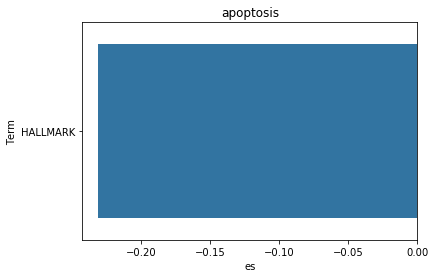

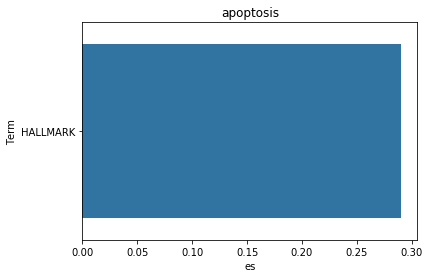

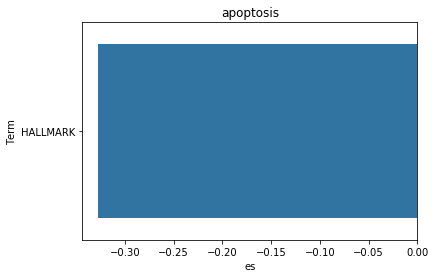

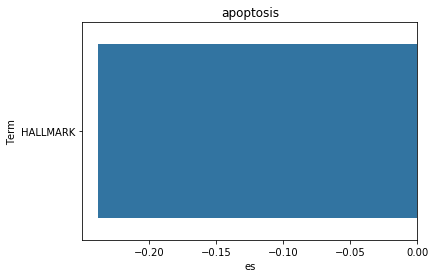

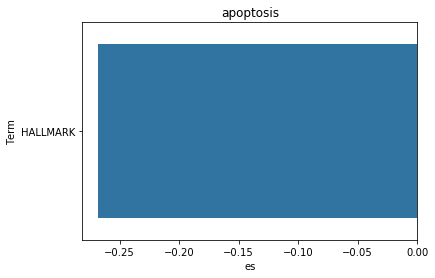

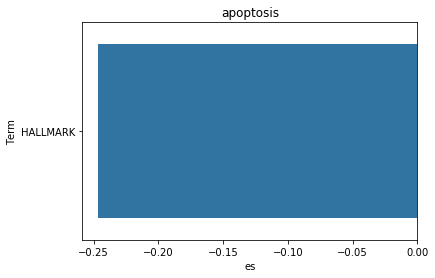

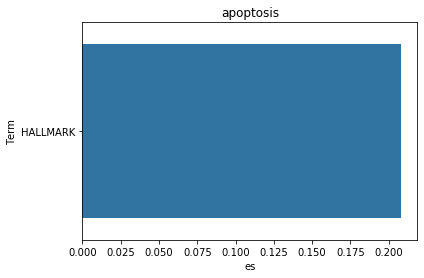

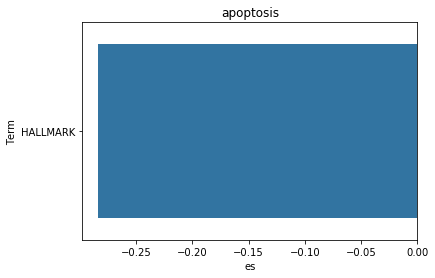

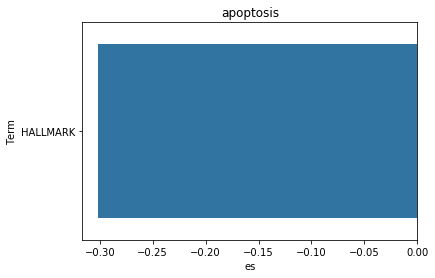

In [54]:
for i, check in enumerate(checks[1:]): 
    print(check)
    totest = counts[[v for v in counts.columns if check[0] in v and check[1] in v or '0h' in v]]
    cls = ['DMSO' if '0h' in v else 'Condition' for v in totest.columns]
    dat = gseapy.gsea(data=totest, gene_sets='data/apoptosis.gmt', 
                cls= cls, no_plot=False, processes=6)
    dat.res2d['Term'] = [i.split('_')[0][:50] for i in dat.res2d.index]
    plt.figure(i)
    sns.barplot(data=dat.res2d, x="es", y="Term",
                hue_order="geneset_size").set_title('apoptosis')

## Results

It seems looking at both plottings of raw RNA data and Differential Expression analysis, that the RNA seq experiment is sound.

However it does not completly match to the theory. We can see some of the CTF as showing differential expression but they are not the most differentially expressed ones. 
This could amount to noise. 

It seems however, looking at the TNSE and MDS plots, that the samples underwent a transcriptional adaptation to the presence of different element. This state change could be attributable to the CTFs. But it seemed to be a transcriptional adaptation rather than transcriptional collapse. Moreover, given the experimental set up (using PCR, renormalizing the RNA) it might be difficult to see transcriptional collaps.

### DESEQ2

you might have seen that more complex variance analysis can be achieved. However it seems that with the little data at hand and the assumption that these more complex models will achieve, staying on a simpler differential expression formula allows better results. I have tried a few and it seemed to confirm this suspicion (or I would need to provide a better model than DESEQ has to offer) limma.voom?